In [6]:
from PIL import Image, ImageOps
import torch
from torchvision import transforms, datasets
import rasterio
import math
import os
import numpy as np
import cv2
Image.MAX_IMAGE_PIXELS = None # Disable DecompressionBombError，解决PIL的像素限制问题

# Utils

In [2]:
# WGS-84经纬度转Web墨卡托
def wgs_to_mercator(x, y):
    y = 85.0511287798 if y > 85.0511287798 else y
    y = -85.0511287798 if y < -85.0511287798 else y

    x2 = x * 20037508.34 / 180
    y2 = math.log(math.tan((90 + y) * math.pi / 360)) / (math.pi / 180)
    y2 = y2 * 20037508.34 / 180
    return x2, y2

# Web墨卡托转经纬度
def mercator_to_wgs(x, y):
    x2 = x / 20037508.34 * 180
    y2 = y / 20037508.34 * 180
    y2 = 180 / math.pi * \
        (2 * math.atan(math.exp(y2 * math.pi / 180)) - math.pi / 2)
    return x2, y2

In [3]:
#wgs84和gcj02的纠偏与互转

def transformLat(x, y):
    ret = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * \
        y + 0.1 * x * y + 0.2 * math.sqrt(abs(x))
    ret += (20.0 * math.sin(6.0 * x * math.pi) + 20.0 *
            math.sin(2.0 * x * math.pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(y * math.pi) + 40.0 *
            math.sin(y / 3.0 * math.pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(y / 12.0 * math.pi) + 320 *
            math.sin(y * math.pi / 30.0)) * 2.0 / 3.0
    return ret


def transformLon(x, y):
    ret = 300.0 + x + 2.0 * y + 0.1 * x * x + \
        0.1 * x * y + 0.1 * math.sqrt(abs(x))
    ret += (20.0 * math.sin(6.0 * x * math.pi) + 20.0 *
            math.sin(2.0 * x * math.pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(x * math.pi) + 40.0 *
            math.sin(x / 3.0 * math.pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(x / 12.0 * math.pi) + 300.0 *
            math.sin(x / 30.0 * math.pi)) * 2.0 / 3.0
    return ret


def delta(lat, lon):
    ''' 
    Krasovsky 1940
    //
    // a = 6378245.0, 1/f = 298.3
    // b = a * (1 - f)
    // ee = (a^2 - b^2) / a^2;
    '''
    a = 6378245.0  # a: 卫星椭球坐标投影到平面地图坐标系的投影因子。
    ee = 0.00669342162296594323  # ee: 椭球的偏心率。
    dLat = transformLat(lon - 105.0, lat - 35.0)
    dLon = transformLon(lon - 105.0, lat - 35.0)
    radLat = lat / 180.0 * math.pi
    magic = math.sin(radLat)
    magic = 1 - ee * magic * magic
    sqrtMagic = math.sqrt(magic)
    dLat = (dLat * 180.0) / ((a * (1 - ee)) / (magic * sqrtMagic) * math.pi)
    dLon = (dLon * 180.0) / (a / sqrtMagic * math.cos(radLat) * math.pi)
    return {'lat': dLat, 'lon': dLon}


def outOfChina(lat, lon):
    if (lon < 72.004 or lon > 137.8347):
        return True
    if (lat < 0.8293 or lat > 55.8271):
        return True
    return False


def gcj_to_wgs(gcjLon, gcjLat):
    if outOfChina(gcjLat, gcjLon):
        return (gcjLon, gcjLat)
    d = delta(gcjLat, gcjLon)
    return (gcjLon - d["lon"], gcjLat - d["lat"])


def wgs_to_gcj(wgsLon, wgsLat):
    if outOfChina(wgsLat, wgsLon):
        return wgsLon, wgsLat
    d = delta(wgsLat, wgsLon)
    return wgsLon + d["lon"], wgsLat + d["lat"]

In [4]:
a, b = wgs_to_mercator(114.073989, 22.672775)
a, b

(12698658.366469823, 2592493.9833760057)

# Remote

In [10]:
path = '../Datasets'
fsize = os.path.getsize(os.path.join(path,'amap_18_ns_satellite.tif')) #获取文件大小,单位为byte
fsize = fsize/float(1024*1024*1024) #单位变成G
fsize

6.543348388746381

In [2]:
#通过rasterio库读取tiff文件信息

# Open the GeoTIFF file
with rasterio.open('../Datasets/amap_18_ns_satellite.tif') as dataset:
    # Access the geospatial metadata
    metadata = dataset.meta
    print(f"metadata:{metadata}") 

    # Access the spatial reference system (SRS)
    srs = dataset.crs
    print(f"srs:{srs}")

    # Access the geotransform, which includes the coordinate information
    transform = dataset.transform
    print(transform)

    # Access specific information like longitude and latitude bounds
    min_lon, min_lat = transform * (0, 0)  # Top-left corner
    max_lon, max_lat = transform * (dataset.width, dataset.height)  # Bottom-right corner
    print("Longitude range:", min_lon, max_lon)
    print("Latitude range:", min_lat, max_lat)
    
    print(type(transform))
    print(f'坐标范围：{dataset.bounds}')

metadata:{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 45056, 'height': 51968, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.5971642834779645, 0.0, 12665921.334966816,
       0.0, -0.5971642834779702, 2590450.8885846175)}
srs:EPSG:3857
| 0.60, 0.00, 12665921.33|
| 0.00,-0.60, 2590450.89|
| 0.00, 0.00, 1.00|
Longitude range: 12665921.334966816 12692827.1689232
Latitude range: 2590450.8885846175 2559417.4551008344
<class 'affine.Affine'>
坐标范围：BoundingBox(left=12665921.334966816, bottom=2559417.4551008344, right=12692827.1689232, top=2590450.8885846175)


In [5]:
dataset.bounds.left,dataset.bounds.bottom,dataset.bounds.right,dataset.bounds.top

(12665921.334966816, 2559417.4551008344, 12692827.1689232, 2590450.8885846175)

# Road

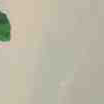

In [22]:
#compose的使用
#image = Image.open('../Datasets/custom_ns_road.png')
image = Image.open('../Datasets/amap_12_ns_satellite.png')
transform = transforms.Compose([
    #transforms.Resize([1024,1024])
    transforms.RandomCrop([104,104])

])
image2 = transform(image)
image2

In [7]:
#路网图裁剪，使用cv2库,cv2库无法读取很大的图像，只能pil库读取完转换为numpy

def crop_edges(image, width_to_crop, height_to_crop):
    # Get the dimensions of the original image
    height, width = image.shape[:2]

    # Calculate the cropping dimensions
    left = width_to_crop
    upper = height_to_crop
    right = width - width_to_crop
    lower = height - height_to_crop

    # Crop the image using OpenCV
    cropped_image = image[upper:lower, left:right]

    return cropped_image

# Load the image using OpenCV
image_path = '../Datasets/mask_all/national_road.png'
original_image = Image.open(image_path)

original_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGBA2BGRA) 

# Define the number of pixels to crop from the edges
width_to_crop = 1263  # Half the width of the image
height_to_crop = 697  # Half the height of the image

cropped_image = crop_edges(original_image, width_to_crop, height_to_crop)

# Save the cropped image to a new file
cv2.imwrite('../Datasets/mask_all/national_road_T.png', cropped_image)

True